In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import jax
import jax_cosmo as jc
import jax.numpy as np
from DifferentiableHOS.Plot import plot_contours
cosmo_jax = jc.Planck15()

Populating the interactive namespace from numpy and matplotlib


In [29]:
results_dict = pickle.load( open( "/global/u1/d/dlan/DifferentiableHOS/scripts/128_results_2.pkl", "rb" ) )

ps=results_dict['ps']
jac=results_dict['jac']
ell=results_dict['ell']

In [41]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(1.)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, ell, probes)
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes,f_sky=10000/41252, sparse=True);

/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [42]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)


In [43]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
F1= jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)


Populating the interactive namespace from numpy and matplotlib


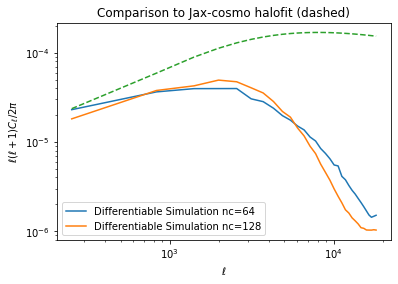

In [52]:
%pylab inline
l=ell
loglog(l, l*(l+1)*ps/(2*pi),label='Differentiable Simulation nc=128')
loglog(l, l*(l+1)*cls[0]/(2*pi), '--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
#xlim(1,1e3)
xlabel('$\ell$')
title('Comparison to Jax-cosmo halofit (dashed)')
legend()
savefig('momcompnc.png',dpi=80)



In [53]:
ps_=np.mean([ps,ps2],axis=0)
jac_=np.mean([jac,jac2],axis=0)

Populating the interactive namespace from numpy and matplotlib


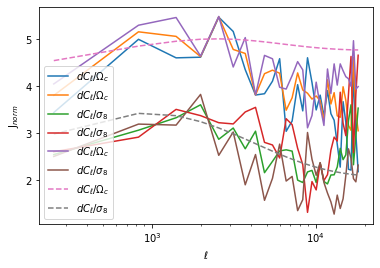

In [39]:
%pylab inline
semilogx(ell,jac[:,0]/ps,label='$dC_\ell/\Omega_c$')
semilogx(ell,jac[:,1]/ps,label='$dC_\ell/\sigma_8$')
semilogx(ell,dmu[:,0]/cls[0],'--',label='$dC_\ell/\Omega_c$')
semilogx(ell,dmu[:,1]/cls[0],'--',label='$dC_\ell/\sigma_8$')
ylabel('J$_{norm}$')
xlabel('$\ell$')
#xlim(0,3000)
#savefig('momcomp6.png',dpi=80)
legend()

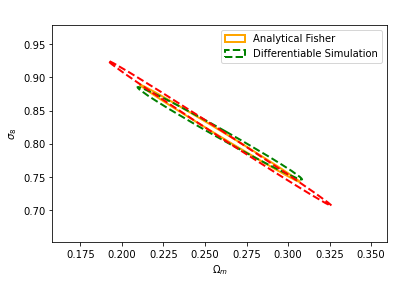

In [46]:
ax = plt.axes()
#ax.set_facecolor('black')
ax1=plot_contours(F, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
ax2=plot_contours(F1, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_m$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_m$ and $\sigma_8$ from Power Spectrum ',color='white')
plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'])

In [5]:
ps_array=[]
jac_array=[]
for i in (range(11)):
    results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/results"+str(i)+".pkl", "rb" ) )
    ps=results_dict['ps']
    jac=results_dict['jac']
    ps_array.append(ps)
    jac_array.append(jac)
ell=results_dict['ell']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/results0.pkl'

In [73]:
ps=np.mean(np.stack(ps_array),axis=0)
jac=np.mean(np.stack(jac_array),axis=0)

In [129]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(1.)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, ell[0], probes)
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell[0], probes,f_sky=10000/41252, sparse=True);


/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [130]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell[0], probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)


In [131]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
F1= jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)

Populating the interactive namespace from numpy and matplotlib


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0.5, 1.0, 'Comparison to Jax-cosmo halofit (dashed)')

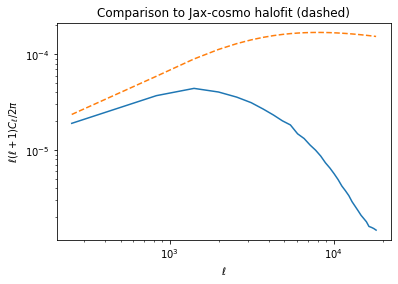

In [132]:
%pylab inline
l=ell[0]
loglog(l, l*(l+1)*ps/(2*pi))
loglog(l, l*(l+1)*cls[0]/(2*pi), '--',)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
#xlim(1,1e3)
xlabel('$\ell$')
title('Comparison to Jax-cosmo halofit (dashed)')

Populating the interactive namespace from numpy and matplotlib


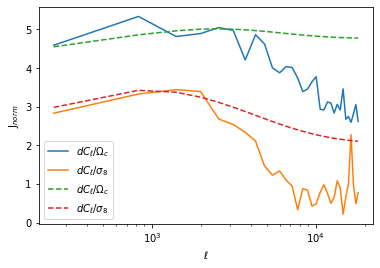

In [134]:
%pylab inline
semilogx(ell[0],jac[:,0]/ps,label='$dC_\ell/\Omega_c$')
semilogx(ell[0],jac[:,1]/ps,label='$dC_\ell/\sigma_8$')
semilogx(ell[0],dmu[:,0]/cls[0],'--',label='$dC_\ell/\Omega_c$')
semilogx(ell[0],dmu[:,1]/cls[0],'--',label='$dC_\ell/\sigma_8$')
ylabel('J$_{norm}$')
xlabel('$\ell$')
#xlim(0,3000)
#savefig('momcomp6.png',dpi=80)
legend()

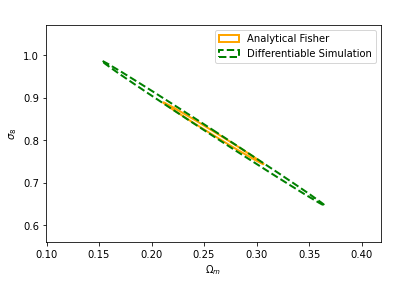

In [133]:
ax = plt.axes()
#ax.set_facecolor('black')
ax1=plot_contours(F, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
ax2=plot_contours(F1, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_m$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_m$ and $\sigma_8$ from Power Spectrum ',color='white')
plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'])
#savefig('fisher_black.png',dpi=150)

In [138]:
el=ell[0][:5]
ja=jac[:5]


In [139]:
ps_r=ps[:5]

In [140]:

cls_r = jc.angular_cl.angular_cl(cosmo, el, probes)
mu_r, cov_r = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, el, probes,f_sky=10000/41252, sparse=True);
def mean_fn_r(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, el, probes)
  return m.flatten()
jac_mean_r = jax.jit(jax.jacfwd(mean_fn_r)) 
dmu_r = jac_mean_r(params)

In [141]:
F_r = jc.sparse.dot(dmu_r.T, jc.sparse.inv(cov_r), dmu_r)
F1_r= jc.sparse.dot(ja.T, jc.sparse.inv(cov_r), ja)

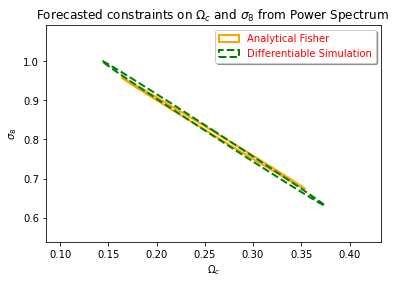

In [152]:
ax = plt.axes()
#ax.set_facecolor('black')
ax1=plot_contours(F_r, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
ax2=plot_contours(F1_r, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_c$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_c$ and $\sigma_8$ from Power Spectrum ',color='black')
leg =plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'],shadow=True)
leg.texts[0].set_color('red')
leg.texts[1].set_color('red')
savefig('fisher_mean.png',dpi=150)

In [61]:
stages = np.linspace(0.1, 1., 30, endpoint=True)

In [65]:
stages


array([0.1       , 0.13103448, 0.16206897, 0.19310345, 0.22413793,
       0.25517241, 0.2862069 , 0.31724138, 0.34827586, 0.37931034,
       0.41034483, 0.44137931, 0.47241379, 0.50344828, 0.53448276,
       0.56551724, 0.59655172, 0.62758621, 0.65862069, 0.68965517,
       0.72068966, 0.75172414, 0.78275862, 0.8137931 , 0.84482759,
       0.87586207, 0.90689655, 0.93793103, 0.96896552, 1.        ])

In [64]:
z=1/stages-1

In [66]:
z

array([9.        , 6.63157895, 5.17021277, 4.17857143, 3.46153846,
       2.91891892, 2.4939759 , 2.15217391, 1.87128713, 1.63636364,
       1.43697479, 1.265625  , 1.11678832, 0.98630137, 0.87096774,
       0.76829268, 0.67630058, 0.59340659, 0.51832461, 0.45      ,
       0.38755981, 0.33027523, 0.27753304, 0.22881356, 0.18367347,
       0.14173228, 0.1026616 , 0.06617647, 0.03202847, 0.        ])